<img src="https://healthybeat.com/wp-content/uploads/2020/08/How_Many_Steps_in_a_Mile_or_Kilometer-01-scaled.jpg" width = 800px height = 600px>

# **Time Series Analysis of Daily Steps Data**

- **Mlondi**

## Table of contents
1. [Introduction](#intro)
2. [Data Collection](#data)
3. [Data Preprocessing](#cleaning)
4. [Exploratory Data Analysis](#EDA)
5. [Test seasonality and Stationarity](#features)
6. [Model Selection](#model)
7. [Conclusion](#conclusion)
8. [References](#references)

<a id="intro"></a>
# 1. **Introduction**

#### **Objective**

1. Explore the overall trends in daily steps taken by the individual.
2. Identify any seasonality or recurring pa:erns in the data.
3. Forecast the time series and test the fitness of it.

<a id="data"></a>
# 2. **Data Collection**

Dataset: The fitness dataset comprises daily steps measurements for 15 months. It includes 
the following variables:
1. **Date:** The date of the measurement.
2. **Steps:** The number of step
3. **Goal:** A daily steps goal

# **Importing Libraries**

In [208]:
import numpy as np
import pandas as pd
from datetime import datetime

import warnings
import itertools
import matplotlib.pyplot as plt
import plotly.express as px

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")
import matplotlib
%matplotlib inline

<a id="cleaning"></a>
## 3. **Data Preprocessing**

Data preprocessing is a technique that involves taking in raw data and transforming it into a understandable format and useful. The technique includes data cleaning, intergration, transformation, reduction and discretization. The data preprocessing plan will include the following processes:


1. Table merging process.
2. Checking and dealing with missing values.

- We read and merge the 15 files into one DataFrame.

In [209]:
# Reading all data files
df_1 = pd.DataFrame({})

for i in range(1,16):
    path = 'Steps'+str(i)+'.csv'
    df_temp = pd.read_csv(path)
    df_1 = pd.concat([df_1,df_temp], axis = 0)
    
df_1.head()

,Date,Actual,Goal
0,May 31 2022,0,8000
1,Jun 1 2022,0,8000
2,Jun 2 2022,0,8000
3,Jun 3 2022,1102,8000
4,Jun 4 2022,1254,8000


In [210]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 420 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    420 non-null    object
 1   Actual  420 non-null    int64 
 2   Goal    420 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 13.1+ KB


In [211]:
# converting the date to an appropriate date format 
df_1['Date'] = df_1['Date'].apply(lambda x: datetime.strptime(x,'%b %d %Y').strftime('%Y-%m-%d'))
df_1['Date'] = pd.to_datetime(df_1['Date'])

In [212]:
# Replacing zeros as nulls and changing datatype
df_1['Actual'] = df_1['Actual'].replace(0, np.nan)

df_1['Actual'].bfill(inplace = True)

In [213]:
df = df_1.copy()

In [214]:
# set_date index
df.set_index('Date',inplace = True)

In [215]:
df.head()

,Actual,Goal
Date,,
2022-05-31,1102.0,8000
2022-06-01,1102.0,8000
2022-06-02,1102.0,8000
2022-06-03,1102.0,8000
2022-06-04,1254.0,8000


In [216]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420 entries, 2022-05-31 to 2023-07-24
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Actual  420 non-null    float64
 1   Goal    420 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 9.8 KB


<a id="EDA"></a>
## 4. **Exploratory Data Analysis**

An Exploratory Data Analysis is a thorough examination meant to uncover the underlying structure of a data set because it exposes trends, patterns, and relationships that are not readily apparent.

In [217]:
df.describe()

,Actual,Goal
count,420.000000,420.000000
mean,5799.726190,7682.142857
std,2801.384844,613.717635
min,316.000000,6500.000000
25%,3731.250000,8000.000000
50%,5417.500000,8000.000000
75%,7362.250000,8000.000000
max,16611.000000,8000.000000


In [218]:
a = list(df[['Actual']].values)
print("- The 90th percentile is {}.".format(round(np.nanpercentile(a,90))))
print("")
print("- The 99th percentile is {}.".format(round(np.nanpercentile(a,99))))

- The 90th percentile is 9393.

- The 99th percentile is 15258.


- Standard deviation is large which means that the data points are spread far from the **mean = 5839**, and some of them are very different from the average value.


**The maximum value is Approximately;**
- 3 times the mean,
- 52 times the min value,
- 2 times the 75th percentile,
- 1.7 times the 90th percentile.

This shows how scattered the data points are.

In [219]:
# drop Goal column
df = df.drop(['Goal'],axis = 1)

In [220]:
fig = px.line(df, x=df.index, y="Actual",width=900, height=300)

# Center the title
fig.update_layout(title_text='Actual Steps with time', title_x=0.5)

fig.show()

<a id="features"></a>
## 5. **Test seasonality and Stationarity**

In [221]:
def adf_test(actual):
    
    """takes in the data and checks if the data is stationary or not
    input: dataframe e.g df[column]
    output: prints where data is stationary or not"""
    actual = actual.dropna()
    
    result = adfuller(actual, autolag='AIC')
    
    labels = ['Test parameters', 'p-value','#Lags Used','Dataset observations']
    
    for value,label in zip(result,labels):
        
        print(label+' : '+str(value))
        
    if result[1] <= 0.05:
        
        print("Dataset is stationary")
        
    else:
        print("Dataset is non-stationary ")

In [222]:
# Augmented Dickey-Fuller
adf_test(df['Actual'])

Test parameters : -4.7256657217888565
p-value : 7.52904975674442e-05
#Lags Used : 15
Dataset observations : 404
Dataset is stationary


### Getting the best 'd', 'p' and 'q' values

We need parameter combinations of the form *(p, d, q) x (P, D, Q, s)*. We look for a combination with the smallest AIC score.
- AIC: The Akaike information criterion (AIC) is a metric that is used to compare the fitness of a model.

In [223]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df['Actual'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:8541.46120302584
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:8147.404828254961
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:7900.028149803181
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:7493.809617559235
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:7888.673219109294
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:7727.9739041354205
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:7583.6569355326055
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:7490.786387300258
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:8335.299645868643
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:8042.7019144529295
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:7849.784138944609
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:7436.487611970004
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:7843.013617653163
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:7670.430969933923
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:7568.85327543389
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:7438.4859746038655
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:8001.630721458486
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:7781.0608000330985
ARIMA(0

- The combination with the smallest AIC value is  (0, 1, 1)x(1, 1, 1, 12)

<a id="model"></a>
## 6. **Model Selection**

### Implementing and Training the ARIMA model

In [224]:
# instantiate model
arima_model = ARIMA(df['Actual'],
              order = (1,0,1),
             freq = 'D',
             missing = 'drop')

# train model
arima_model = arima_model.fit()

### Visualising the ARIMA model prediction

<AxesSubplot:xlabel='Date'>

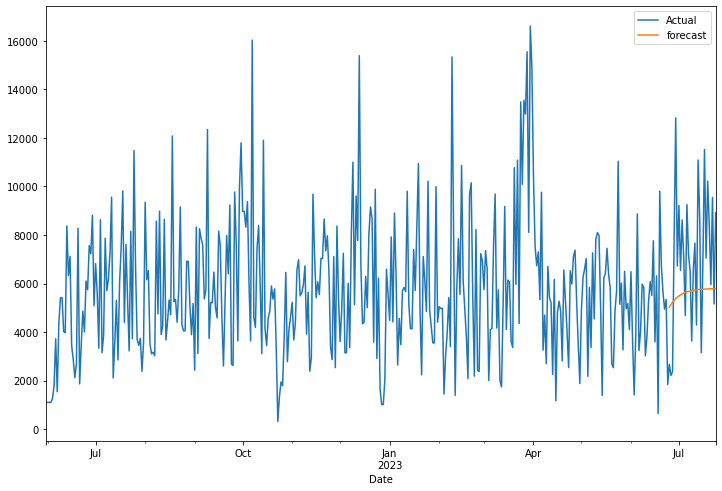

In [225]:
# focasting
df['forecast'] = arima_model.predict(start = 390
                                     ,end = 419
                                     ,dynamic = True)
# visualising
df[['Actual','forecast']].plot(figsize=(12,8))

- It is clear that our forecast is way off. The ARIMA model has not performed well since it has not made correct predictions. The orange line is far apart from the blue line.

### Evaluating the ARIMA model

In [226]:
# get predictions
results = arima_model.get_prediction(start = pd.to_datetime('2023-06-25'),
                                     dynamic = False)

#predicted and real values
y_pred = np.array(results.predicted_mean)
y_actual = np.array(df['2023-06-25':]['Actual'])

#mean_squared_error
mse = mean_squared_error(y_actual, y_pred)
print('The mean_squared_error for the ARIMA Model is {}'.format(mse))

The mean_squared_error for the ARIMA Model is 7814693.790897408


### Implementing and Training the SARIMA model

In [227]:
# instantiate model
sarima_model = sm.tsa.statespace.SARIMAX(df['Actual']
                                         ,order=(1, 0, 1)
                                         ,seasonal_order =(1,1,1,12)
                                         ,enforce_stationarity = False
                                         ,enforce_invertibility = False)
# train model
sarima_model = sarima_model.fit()

### Visualising the SARIMA model prediction

<AxesSubplot:xlabel='Date'>

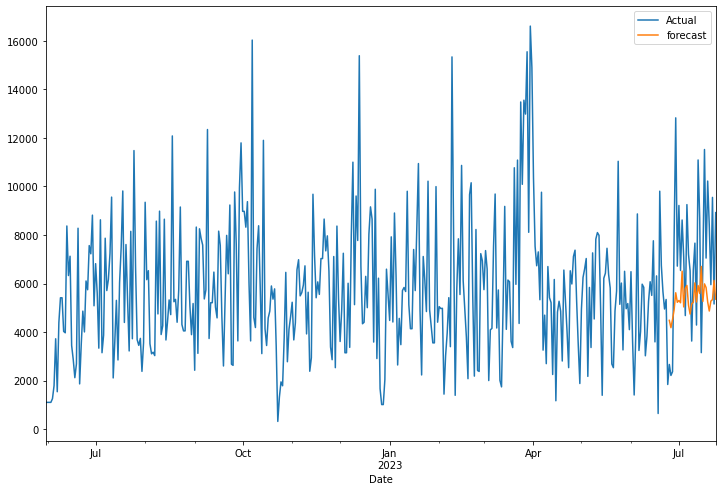

In [228]:
# forecast
df['forecast'] = sarima_model.predict(start = 390
                                      ,end = 419
                                      ,dynamic=True)
# visualise
df[['Actual','forecast']].plot(figsize=(12,8))

### Evaluating the SARIMA model

In [229]:
# get predictions
results = sarima_model.get_prediction(start = pd.to_datetime('2023-06-25'),
                                     dynamic = False)

#predicted and real values
y_pred = np.array(results.predicted_mean)
y_actual = np.array(df['2023-06-25':]['Actual'])

#finding the mse
mse = np.sqrt(mean_squared_error(y_actual, y_pred))
print('The mean_squared_error for the SARIMA Model is {}'.format(mse))

The mean_squared_error for the SARIMA Model is 2764.452822306989


<a id="conclusion"></a>
## 7. **Conclusion**

We have built a univariate time series model with ARIMA and SARIMA. We also looked at time-series stationarity using Augmented Dickey-Fuller test.

Finally, we implemented both the ARIMA and SARIMA models. The SARIMA model made better predictions.

<a id="references"></a>
## 8. **References**

https://www.nbshare.io/notebook/136553745/Time-Series-Analysis-Using-ARIMA-From-StatsModels/

https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

https://www.section.io/engineering-education/univariate-time-series-analysis-with-arima-in-python/